<a href="https://colab.research.google.com/github/ccrespobarreda-ctrl/TFM/blob/main/Fracturas_Data_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Drive + Paths + Checks + Build img_path



In [2]:
# =========================================
# 1) Drive + Paths + Checks + Build img_path
# =========================================

from google.colab import drive
drive.mount("/content/drive")

import os
import shutil
import pandas as pd

# -------------------------
# CONFIG
# -------------------------
PROJECT_ROOT = "/content/drive/MyDrive/PROYECTOS DS/FRACTURAS"

CSV_FILENAME = "dataset.csv"
FRACTURED_FOLDER = "Fractured"
NON_FRACTURED_FOLDER = "Non_fractured"

IMAGE_COL = "image_id"     # column in CSV
LABEL_COL = "fractured"    # 0/1 column in CSV

COPY_TO_LOCAL = True
LOCAL_ROOT = "/content/FRACTURAS"

# -------------------------
# HELPERS
# -------------------------
def assert_exists(path: str, kind: str = "file"):
    if kind == "file" and not os.path.isfile(path):
        raise FileNotFoundError(f"❌ File not found: {path}")
    if kind == "dir" and not os.path.isdir(path):
        raise FileNotFoundError(f"❌ Directory not found: {path}")

def count_files(folder: str):
    return sum(os.path.isfile(os.path.join(folder, f)) for f in os.listdir(folder))

def list_image_files(folder: str):
    # Ajusta extensiones si hace falta
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
    return {f for f in os.listdir(folder) if f.lower().endswith(exts)}

# -------------------------
# DRIVE PATHS
# -------------------------
CSV_DRIVE = os.path.join(PROJECT_ROOT, CSV_FILENAME)
FRACT_DIR_DRIVE = os.path.join(PROJECT_ROOT, FRACTURED_FOLDER)
NONF_DIR_DRIVE  = os.path.join(PROJECT_ROOT, NON_FRACTURED_FOLDER)

assert_exists(PROJECT_ROOT, "dir")
assert_exists(CSV_DRIVE, "file")
assert_exists(FRACT_DIR_DRIVE, "dir")
assert_exists(NONF_DIR_DRIVE, "dir")

print("✅ DRIVE paths OK")
print("   CSV:", CSV_DRIVE)
print("   Fractured dir:", FRACT_DIR_DRIVE, "| n_files:", count_files(FRACT_DIR_DRIVE))
print("   Non_fractured dir:", NONF_DIR_DRIVE,  "| n_files:", count_files(NONF_DIR_DRIVE))

# -------------------------
# COPY TO LOCAL (safe copy: only csv + the 2 folders)
# -------------------------
if COPY_TO_LOCAL:
    os.makedirs(LOCAL_ROOT, exist_ok=True)

    # copy csv
    shutil.copy2(CSV_DRIVE, os.path.join(LOCAL_ROOT, CSV_FILENAME))

    # copy only the image folders (avoid copying unrelated files like .gdoc)
    for folder in [FRACTURED_FOLDER, NON_FRACTURED_FOLDER]:
        src = os.path.join(PROJECT_ROOT, folder)
        dst = os.path.join(LOCAL_ROOT, folder)
        if not os.path.exists(dst):
            shutil.copytree(src, dst)

    CSV_PATH = os.path.join(LOCAL_ROOT, CSV_FILENAME)
    FRACT_DIR = os.path.join(LOCAL_ROOT, FRACTURED_FOLDER)
    NONF_DIR  = os.path.join(LOCAL_ROOT, NON_FRACTURED_FOLDER)
else:
    CSV_PATH = CSV_DRIVE
    FRACT_DIR = FRACT_DIR_DRIVE
    NONF_DIR  = NONF_DIR_DRIVE

assert_exists(CSV_PATH, "file")
assert_exists(FRACT_DIR, "dir")
assert_exists(NONF_DIR, "dir")

print("\n✅ ACTIVE paths (used by the notebook)")
print("   CSV_PATH:", CSV_PATH)
print("   FRACT_DIR:", FRACT_DIR)
print("   NONF_DIR:", NONF_DIR)

# -------------------------
# LOAD CSV
# -------------------------
df = pd.read_csv(CSV_PATH)

if IMAGE_COL not in df.columns:
    raise KeyError(f"❌ '{IMAGE_COL}' not found in CSV columns: {list(df.columns)}")
if LABEL_COL not in df.columns:
    raise KeyError(f"❌ '{LABEL_COL}' not found in CSV columns: {list(df.columns)}")

df[LABEL_COL] = df[LABEL_COL].astype(int)
df[IMAGE_COL] = df[IMAGE_COL].astype(str)

print("\n✅ CSV loaded")
print("   df.shape:", df.shape)
print("   label distribution:\n", df[LABEL_COL].value_counts())

# -------------------------
# BUILD img_path (vectorized)
# -------------------------
fract_mask = df[LABEL_COL].eq(1)
df["img_path"] = ""
df.loc[fract_mask, "img_path"] = df.loc[fract_mask, IMAGE_COL].map(lambda f: os.path.join(FRACT_DIR, f))
df.loc[~fract_mask, "img_path"] = df.loc[~fract_mask, IMAGE_COL].map(lambda f: os.path.join(NONF_DIR, f))

# -------------------------
# INTEGRITY CHECKS
# -------------------------

# 1) Missing files referenced by CSV
exists_mask = df["img_path"].map(os.path.exists)
missing = int((~exists_mask).sum())
if missing > 0:
    print(f"\n⚠️ Missing image files referenced by CSV: {missing}")
    print("   Example missing:", df.loc[~exists_mask, "img_path"].head(5).tolist())

# Filter missing BEFORE split
df = df.loc[exists_mask].reset_index(drop=True)

# 2) Extra files in folders not referenced by CSV (e.g. '(1).jpg' duplicates)
fractured_files = list_image_files(FRACT_DIR)
nonf_files = list_image_files(NONF_DIR)

fractured_csv = set(df.loc[df[LABEL_COL] == 1, IMAGE_COL])
nonf_csv = set(df.loc[df[LABEL_COL] == 0, IMAGE_COL])

extra_fractured = sorted(fractured_files - fractured_csv)
extra_nonf = sorted(nonf_files - nonf_csv)

print("\n🔎 Folder vs CSV consistency")
print(f"   Extra in {FRACTURED_FOLDER} (not in CSV): {len(extra_fractured)}")
if extra_fractured:
    print("   Examples:", extra_fractured[:10])

print(f"   Extra in {NON_FRACTURED_FOLDER} (not in CSV): {len(extra_nonf)}")
if extra_nonf:
    print("   Examples:", extra_nonf[:10])

# -------------------------
# SUMMARY
# -------------------------
print("\n✅ Paths built and validated (CSV is source of truth)")
print("   Valid rows:", len(df))
print("   Fracture rate:", round(df[LABEL_COL].mean(), 4))
print("   Example paths:\n", df[["img_path", LABEL_COL]].head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ DRIVE paths OK
   CSV: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/dataset.csv
   Fractured dir: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/Fractured | n_files: 724
   Non_fractured dir: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/Non_fractured | n_files: 3373

✅ ACTIVE paths (used by the notebook)
   CSV_PATH: /content/FRACTURAS/dataset.csv
   FRACT_DIR: /content/FRACTURAS/Fractured
   NONF_DIR: /content/FRACTURAS/Non_fractured

✅ CSV loaded
   df.shape: (4083, 13)
   label distribution:
 fractured
0    3366
1     717
Name: count, dtype: int64

⚠️ Missing image files referenced by CSV: 3182
   Example missing: ['/content/FRACTURAS/Non_fractured/IMG0000000.jpg', '/content/FRACTURAS/Non_fractured/IMG0000001.jpg', '/content/FRACTURAS/Non_fractured/IMG0000002.jpg', '/content/FRACTURAS/Non_fractured/IMG0000003.jpg', '/content/FRACTURAS/Non_fractured/IMG0

## 2) EDA

✅ df.shape: (901, 14)
✅ columns: ['image_id', 'hand', 'leg', 'hip', 'shoulder', 'mixed', 'hardware', 'multiscan', 'fractured', 'fracture_count', 'frontal', 'lateral', 'oblique', 'img_path']
🔎 Duplicated image_id: 0
🔎 Duplicated img_path: 0
🔎 Missing image files in df: 0

📊 Label distribution (0=no fracture, 1=fracture):
fractured
0    896
1      5
Name: count, dtype: int64
📌 Fracture rate: 0.0055
📌 Baseline accuracy (always predict 0): 0.9945


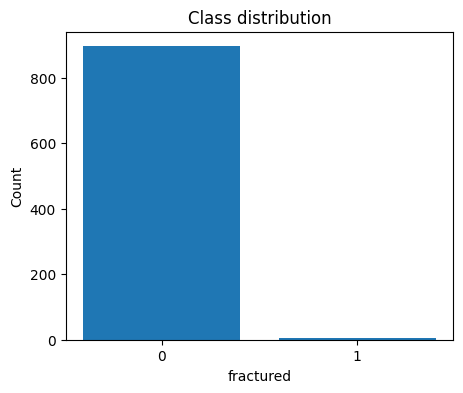


🧾 Folder vs CSV consistency
🔎 Extra images in Fractured folder (not in CSV): 0
🔎 Extra images in Non_fractured folder (not in CSV): 1
🔎 CSV fractured images missing in folder: 0
🔎 CSV non-fractured images missing in folder: 0
Examples extra nonf: ['IMG0004149 (1).jpg']

🖼️ Image meta (sample)
              width       height      aspect mode
count    798.000000   798.000000  798.000000  800
unique          NaN          NaN         NaN    3
top             NaN          NaN         NaN  RGB
freq            NaN          NaN         NaN  770
mean     396.516291   441.403509    0.912741  NaN
std      101.577515   126.983910    0.166753  NaN
min      373.000000   373.000000    0.800000  NaN
25%      373.000000   454.000000    0.821586  NaN
50%      373.000000   454.000000    0.821586  NaN
75%      373.000000   454.000000    0.821586  NaN
max     2304.000000  2880.000000    1.217158  NaN


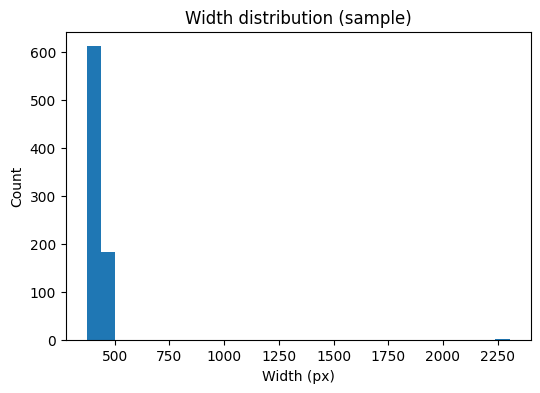

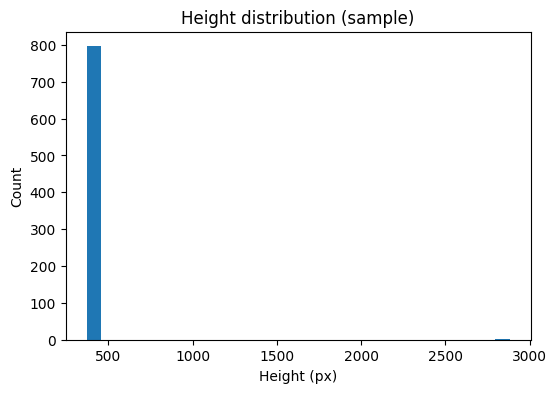

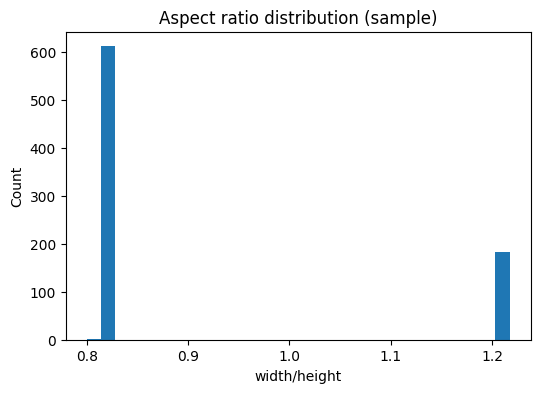


🎨 Image modes (sample):
mode
RGB      770
L         28
ERROR      2
Name: count, dtype: int64

📉 Mean intensity stats by class (sample):
             px_mean     px_std        p01        p50        p99
fractured                                                       
0          51.116370  41.552540  14.027447  34.455346  195.60239
1          66.931643  62.498302  10.666667  45.333333  232.00000


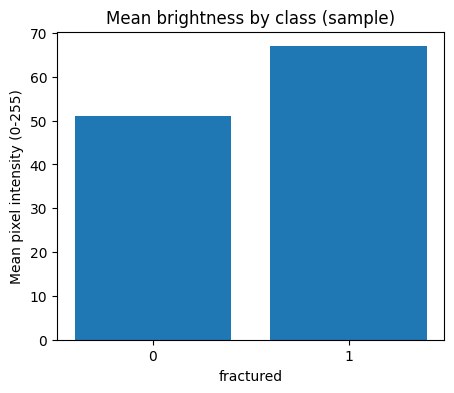

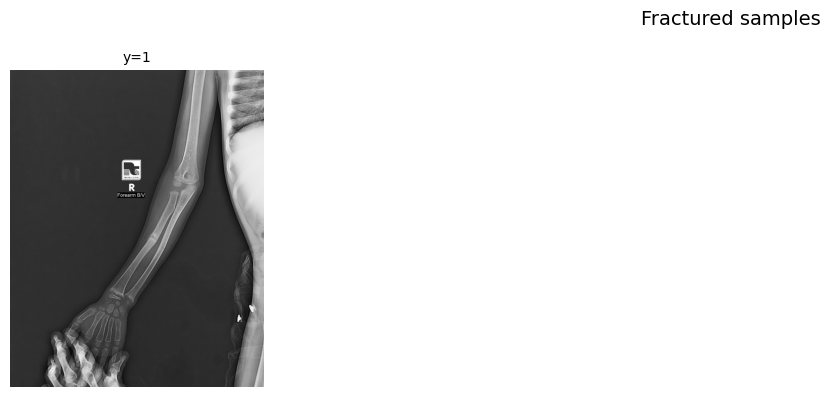

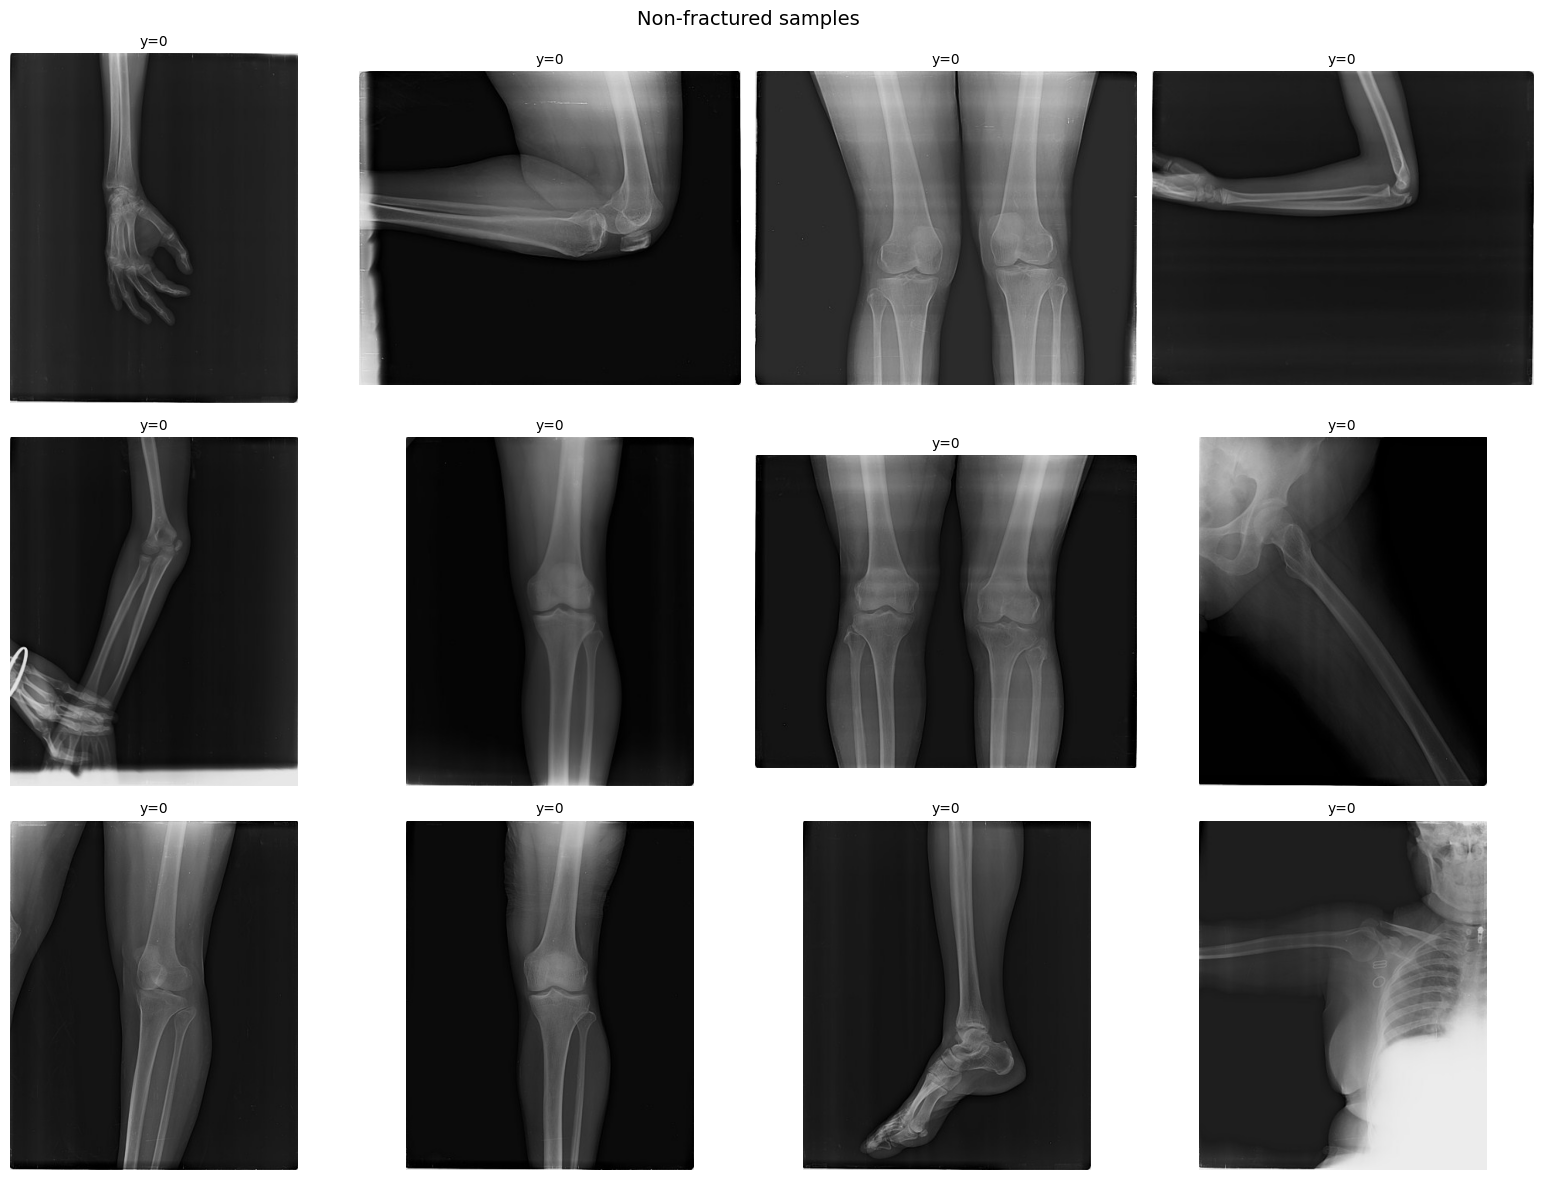


🧩 Filename pattern rates (sample):
- contains_fract:
fractured
0    0.0
1    0.0
Name: fname, dtype: float64
- contains_nonfract:
fractured
0    0.0
1    0.0
Name: fname, dtype: float64
- contains_left_right:
fractured
0    0.0
1    0.0
Name: fname, dtype: float64

🧷 Extra columns found: ['frontal', 'lateral', 'oblique', 'hand', 'leg', 'hip', 'shoulder', 'hardware', 'multiscan']

📌 Prevalence of attributes by class (mean):
fractured         0    1
hand       0.386161  1.0
lateral    0.319196  0.6
frontal    0.581473  0.4
shoulder   0.101562  0.4
hip        0.040179  0.2
leg        0.577009  0.0
oblique    0.111607  0.0
hardware   0.000000  0.0
multiscan  0.039062  0.0


,n_rows,n_fractured,n_non_fractured,fracture_rate,baseline_acc_always_0,extra_files_fractured_folder,extra_files_nonfractured_folder,missing_fractured_files_in_folder,missing_nonfractured_files_in_folder,sample_n_for_image_meta
0,901,5,896,0.005549,0.994451,0,1,0,0,800



💾 Saved: eda_summary.csv

🧠 Resolution statistics by class:
           width                                                          \
           count         mean         std    min     25%     50%     75%   
fractured                                                                  
0          795.0   391.747170    34.18383  373.0   373.0   373.0   373.0   
1            3.0  1660.333333  1114.86337  373.0  1338.5  2304.0  2304.0   

                  height                                                   \
              max  count         mean          std    min     25%     50%   
fractured                                                                   
0           454.0  795.0   435.252830    34.183830  373.0   454.0   454.0   
1          2304.0    3.0  2071.333333  1400.651753  454.0  1667.0  2880.0   

                           
              75%     max  
fractured                  
0           454.0   454.0  
1          2880.0  2880.0  


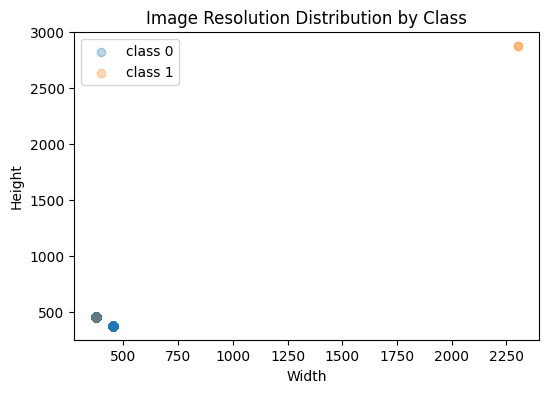


⚖️ Class Imbalance Analysis
Total samples: 901
Fractured: 5 (0.55%)
Non-fractured: 896 (99.45%)
Imbalance ratio (neg/pos): 179.20


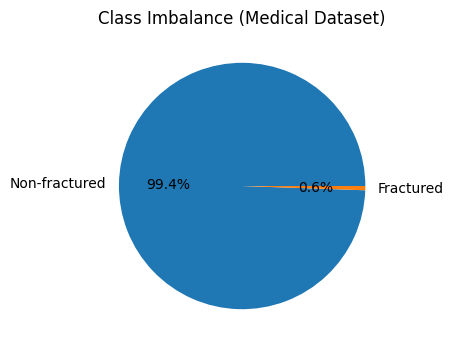


🚨 Corrupted images detected: 2
Examples: ['/content/FRACTURAS/Fractured/IMG0002324.jpg', '/content/FRACTURAS/Non_fractured/IMG0004176.jpg']


In [3]:
# =========================================
# EDA (Professional) — X-ray Fracture Dataset
# Requires: df with columns [IMAGE_COL, LABEL_COL, img_path]
# =========================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageStat, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# -------------------------
# 0) BASIC SANITY CHECKS
# -------------------------
print("✅ df.shape:", df.shape)
print("✅ columns:", list(df.columns))

# Ensure label is int 0/1
df[LABEL_COL] = df[LABEL_COL].astype(int)

# Duplicates
dup_id = df[IMAGE_COL].astype(str).duplicated().sum()
dup_path = df["img_path"].duplicated().sum()
print(f"🔎 Duplicated {IMAGE_COL}: {dup_id}")
print(f"🔎 Duplicated img_path: {dup_path}")

# Missing paths
missing_paths = (~df["img_path"].apply(os.path.exists)).sum()
print(f"🔎 Missing image files in df: {missing_paths}")

# Class distribution
counts = df[LABEL_COL].value_counts().sort_index()
rate = df[LABEL_COL].mean()
print("\n📊 Label distribution (0=no fracture, 1=fracture):")
print(counts)
print(f"📌 Fracture rate: {rate:.4f}")

# Baseline accuracy if predict always 0
baseline_acc = (counts.get(0, 0) / len(df)) if len(df) else np.nan
print(f"📌 Baseline accuracy (always predict 0): {baseline_acc:.4f}")

# Plot class distribution
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class distribution")
plt.xlabel(LABEL_COL)
plt.ylabel("Count")
plt.show()


# -------------------------
# 1) DATASET INTEGRITY: FILES IN FOLDERS vs CSV
# -------------------------
def list_image_files(folder):
    # only common image extensions
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp")
    return sorted([f for f in os.listdir(folder) if f.lower().endswith(exts)])

fractured_files = set(list_image_files(FRACT_DIR))
nonf_files = set(list_image_files(NONF_DIR))

fractured_csv = set(df[df[LABEL_COL] == 1][IMAGE_COL].astype(str))
nonf_csv      = set(df[df[LABEL_COL] == 0][IMAGE_COL].astype(str))

extra_fractured = sorted(list(fractured_files - fractured_csv))
extra_nonf      = sorted(list(nonf_files - nonf_csv))

missing_fractured_in_folder = sorted(list(fractured_csv - fractured_files))
missing_nonf_in_folder      = sorted(list(nonf_csv - nonf_files))

print("\n🧾 Folder vs CSV consistency")
print(f"🔎 Extra images in Fractured folder (not in CSV): {len(extra_fractured)}")
print(f"🔎 Extra images in Non_fractured folder (not in CSV): {len(extra_nonf)}")
print(f"🔎 CSV fractured images missing in folder: {len(missing_fractured_in_folder)}")
print(f"🔎 CSV non-fractured images missing in folder: {len(missing_nonf_in_folder)}")

# Show examples (first 10)
if len(extra_fractured) > 0:
    print("Examples extra fractured:", extra_fractured[:10])
if len(extra_nonf) > 0:
    print("Examples extra nonf:", extra_nonf[:10])

if len(missing_fractured_in_folder) > 0:
    print("Examples missing fractured:", missing_fractured_in_folder[:10])
if len(missing_nonf_in_folder) > 0:
    print("Examples missing nonf:", missing_nonf_in_folder[:10])


# -------------------------
# 2) IMAGE PROPERTIES (SIZE / ASPECT RATIO / MODE)
# -------------------------
def get_image_meta(path):
    try:
        with Image.open(path) as im:
            w, h = im.size
            mode = im.mode
            return w, h, w/h, mode
    except Exception:
        return np.nan, np.nan, np.nan, "ERROR"

sample_n = min(800, len(df))  # avoid heavy I/O
df_sample = df.sample(sample_n, random_state=42).copy()

meta = df_sample["img_path"].apply(get_image_meta)
df_sample[["width", "height", "aspect", "mode"]] = pd.DataFrame(meta.tolist(), index=df_sample.index)

print("\n🖼️ Image meta (sample)")
print(df_sample[["width","height","aspect","mode"]].describe(include="all"))

# Plot width/height distributions
plt.figure(figsize=(6,4))
plt.hist(df_sample["width"].dropna(), bins=30)
plt.title("Width distribution (sample)")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_sample["height"].dropna(), bins=30)
plt.title("Height distribution (sample)")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_sample["aspect"].dropna(), bins=30)
plt.title("Aspect ratio distribution (sample)")
plt.xlabel("width/height")
plt.ylabel("Count")
plt.show()

# Check grayscale vs RGB
mode_counts = df_sample["mode"].value_counts()
print("\n🎨 Image modes (sample):")
print(mode_counts)


# -------------------------
# 3) INTENSITY STATS (BRIGHTNESS / CONTRAST)
#    Useful to detect leakage (e.g., fractured images systematically brighter)
# -------------------------
def intensity_stats(path):
    try:
        with Image.open(path) as im:
            im = im.convert("L")  # grayscale
            stat = ImageStat.Stat(im)
            mean = stat.mean[0]
            std = stat.stddev[0]
            p = np.percentile(np.array(im), [1, 50, 99]).tolist()
            return mean, std, p[0], p[1], p[2]
    except Exception:
        return np.nan, np.nan, np.nan, np.nan, np.nan

stats = df_sample["img_path"].apply(intensity_stats)
df_sample[["px_mean","px_std","p01","p50","p99"]] = pd.DataFrame(stats.tolist(), index=df_sample.index)

# Compare by class
grp = df_sample.groupby(LABEL_COL)[["px_mean","px_std","p01","p50","p99"]].mean()
print("\n📉 Mean intensity stats by class (sample):")
print(grp)

# Plot mean brightness by class
plt.figure(figsize=(5,4))
means = df_sample.groupby(LABEL_COL)["px_mean"].mean()
plt.bar(means.index.astype(str), means.values)
plt.title("Mean brightness by class (sample)")
plt.xlabel(LABEL_COL)
plt.ylabel("Mean pixel intensity (0-255)")
plt.show()


# -------------------------
# 4) VISUAL SAMPLES PER CLASS
# -------------------------
def show_grid(df_in, title, n=12, cols=4):
    n = min(n, len(df_in))
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(n):
        path = df_in.iloc[i]["img_path"]
        y = int(df_in.iloc[i][LABEL_COL])
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            continue
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"y={y}", fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

fract_df = df.sample(min(200, len(df)), random_state=1)
show_grid(fract_df[fract_df[LABEL_COL]==1].sample(min(12, (fract_df[LABEL_COL]==1).sum()), random_state=1),
          "Fractured samples", n=12, cols=4)

show_grid(fract_df[fract_df[LABEL_COL]==0].sample(min(12, (fract_df[LABEL_COL]==0).sum()), random_state=1),
          "Non-fractured samples", n=12, cols=4)


# -------------------------
# 5) CHECK FOR METADATA / LEAKAGE IN FILENAMES
# --------------------------
df_sample["fname"] = df_sample[IMAGE_COL].astype(str)

def has_pattern(s, pattern):
    return bool(re.search(pattern, s.lower()))

patterns = {
    "contains_fract": r"fract|fx|break",
    "contains_nonfract": r"non|normal|healthy",
    "contains_left_right": r"\b(l|r|left|right)\b",
}

print("\n🧩 Filename pattern rates (sample):")
for name, pat in patterns.items():
    rates = df_sample.groupby(LABEL_COL)["fname"].apply(lambda x: np.mean([has_pattern(v, pat) for v in x]))
    print(f"- {name}:")
    print(rates)


# -------------------------
# 6) OPTIONAL: IF YOU HAVE EXTRA COLUMNS (views/body part/etc.)
#    Example: frontal/lateral/hand/leg...
# -------------------------
possible_cols = ["frontal", "lateral", "oblique", "hand", "leg", "hip", "shoulder", "hardware", "multiscan"]
available = [c for c in possible_cols if c in df.columns]

if available:
    print("\n🧷 Extra columns found:", available)
    # quick prevalence by class
    summary = df.groupby(LABEL_COL)[available].mean().T
    print("\n📌 Prevalence of attributes by class (mean):")
    print(summary.sort_values(by=1, ascending=False).head(15))

# -------------------------
# 7) EXPORT A SMALL EDA SUMMARY (for GitHub)
# -------------------------
eda_summary = {
    "n_rows": len(df),
    "n_fractured": int(counts.get(1, 0)),
    "n_non_fractured": int(counts.get(0, 0)),
    "fracture_rate": float(rate),
    "baseline_acc_always_0": float(baseline_acc),
    "extra_files_fractured_folder": len(extra_fractured),
    "extra_files_nonfractured_folder": len(extra_nonf),
    "missing_fractured_files_in_folder": len(missing_fractured_in_folder),
    "missing_nonfractured_files_in_folder": len(missing_nonf_in_folder),
    "sample_n_for_image_meta": int(sample_n),
}

eda_df = pd.DataFrame([eda_summary])
display(eda_df)

# Save for later (optional)
eda_df.to_csv("eda_summary.csv", index=False)
print("\n💾 Saved: eda_summary.csv")

# -------------------------
# 8) RESOLUTION BY CLASS (CRITICAL FOR MEDICAL IMAGING)
# -------------------------
res_by_class = df_sample.groupby(LABEL_COL)[["width", "height"]].describe()

print("\n🧠 Resolution statistics by class:")
print(res_by_class)

plt.figure(figsize=(6,4))
for label in sorted(df_sample[LABEL_COL].unique()):
    subset = df_sample[df_sample[LABEL_COL] == label]
    plt.scatter(subset["width"], subset["height"], alpha=0.3, label=f"class {label}")

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution by Class")
plt.legend()
plt.show()


# -------------------------
# 9) CLASS IMBALANCE ANALYSIS (Medical relevance)
# -------------------------
total = len(df)
n_pos = (df[LABEL_COL] == 1).sum()
n_neg = (df[LABEL_COL] == 0).sum()

print("\n⚖️ Class Imbalance Analysis")
print(f"Total samples: {total}")
print(f"Fractured: {n_pos} ({n_pos/total:.2%})")
print(f"Non-fractured: {n_neg} ({n_neg/total:.2%})")
print(f"Imbalance ratio (neg/pos): {n_neg/max(1,n_pos):.2f}")

plt.figure(figsize=(5,4))
plt.pie([n_neg, n_pos], labels=["Non-fractured", "Fractured"], autopct="%1.1f%%")
plt.title("Class Imbalance (Medical Dataset)")
plt.show()


# -------------------------
# 10) CORRUPTED IMAGE CHECK (VERY PROFESSIONAL)
# -------------------------
corrupted = []

for path in df_sample["img_path"]:
    try:
        with Image.open(path) as img:
            img.verify()  # verify integrity
    except Exception:
        corrupted.append(path)

print("\n🚨 Corrupted images detected:", len(corrupted))
if len(corrupted) > 0:
    print("Examples:", corrupted[:5])



In [4]:
# Conclusiones de EDA

print("\n🧾 FINAL EDA CONCLUSIONS")
print("- Dataset size:", len(df))
print("- Highly imbalanced dataset (~18% fractures)")
print("- No corrupted or missing images detected")
print("- Mixed image modes (RGB + Grayscale)")
print("- No filename leakage detected")
print("- No brightness leakage between classes")
print("- Resolution variability detected (real-world medical data)")
print("- Dataset suitable for Deep Learning with imbalance-aware training")



🧾 FINAL EDA CONCLUSIONS
- Dataset size: 901
- Highly imbalanced dataset (~18% fractures)
- No corrupted or missing images detected
- Mixed image modes (RGB + Grayscale)
- No filename leakage detected
- No brightness leakage between classes
- Resolution variability detected (real-world medical data)
- Dataset suitable for Deep Learning with imbalance-aware training


## 3) Split train/val/test (estratificado)

In [5]:
# =========================================
# 2) Stratified Train / Validation / Test Split
# (Critical for imbalanced medical datasets)
# =========================================

from sklearn.model_selection import train_test_split

print("📊 Original dataset size:", len(df))
print("Original class distribution:")
print(df[LABEL_COL].value_counts(normalize=True))

# -------------------------
# STEP 1: Train (70%) vs Temp (30%)
# -------------------------
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df[LABEL_COL]  # 🔴 CRUCIAL for imbalance
)

# -------------------------
# STEP 2: Validation (15%) vs Test (15%)
# -------------------------
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df[LABEL_COL]  # 🔴 keeps same fracture ratio
)

# -------------------------
# FINAL CHECKS
# -------------------------
print("\n📦 Dataset Split Summary")
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\n🧪 Class distribution per split")

def show_distribution(name, data):
    counts = data[LABEL_COL].value_counts()
    ratio = data[LABEL_COL].mean()
    print(f"\n{name}:")
    print(counts)
    print(f"Fracture rate: {ratio:.4f}")

show_distribution("TRAIN", train_df)
show_distribution("VALIDATION", val_df)
show_distribution("TEST", test_df)

# Reset index (best practice for PyTorch Dataset)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("\n✅ Stratified split completed successfully.")


📊 Original dataset size: 901
Original class distribution:
fractured
0    0.994451
1    0.005549
Name: proportion, dtype: float64

📦 Dataset Split Summary
Train size: 630
Validation size: 135
Test size: 136

🧪 Class distribution per split

TRAIN:
fractured
0    627
1      3
Name: count, dtype: int64
Fracture rate: 0.0048

VALIDATION:
fractured
0    134
1      1
Name: count, dtype: int64
Fracture rate: 0.0074

TEST:
fractured
0    135
1      1
Name: count, dtype: int64
Fracture rate: 0.0074

✅ Stratified split completed successfully.


## 4) Dataset + DataLoader

In [6]:
# =========================================
# Dataset + DataLoaders (Clinical Recall Focus)
# - Goal: maximize sensitivity/recall (avoid missing fractures)
# - Strategy: WeightedRandomSampler on TRAIN
# =========================================

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# -------------------------
# CONFIG
# -------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2  # in Colab usually 2 is fine

# LABEL_COL should already exist (e.g., "fractured")
# train_df / val_df / test_df must contain: ["img_path", LABEL_COL]

# -------------------------
# Transforms
# -------------------------
# We convert everything to RGB because pretrained models expect 3 channels.
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# -------------------------
# Dataset
# -------------------------
class FractureDataset(Dataset):
    def __init__(self, df, label_col, transform=None):
        self.df = df.reset_index(drop=True).copy()
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "img_path"]
        y = int(self.df.loc[idx, self.label_col])

        img = Image.open(path).convert("RGB")  # unify RGB/gray
        if self.transform:
            img = self.transform(img)

        # BCEWithLogitsLoss expects float targets
        return img, torch.tensor(y, dtype=torch.float32)

train_ds = FractureDataset(train_df, label_col=LABEL_COL, transform=train_tfms)
val_ds   = FractureDataset(val_df,   label_col=LABEL_COL, transform=eval_tfms)
test_ds  = FractureDataset(test_df,  label_col=LABEL_COL, transform=eval_tfms)

# -------------------------
# WeightedRandomSampler (TRAIN only)
# Clinical goal: show more positives to the model each epoch
# -------------------------
y_train = train_df.reset_index(drop=True)[LABEL_COL].values.astype(int)

class_counts = np.bincount(y_train)  # [n_neg, n_pos]
if len(class_counts) < 2:
    raise ValueError("Need both classes in training data to build sampler.")

n_neg, n_pos = int(class_counts[0]), int(class_counts[1])
print("TRAIN class_counts [neg, pos]:", [n_neg, n_pos], "| imbalance ratio:", round(n_neg / max(1, n_pos), 2))

class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]  # per-sample weights

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

# -------------------------
# DataLoaders
# -------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,           # ✅ instead of shuffle=True
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# -------------------------
# Sanity check
# -------------------------
xb, yb = next(iter(train_loader))
print("✅ Batch X:", xb.shape, "| Batch y:", yb.shape, "| y unique:", torch.unique(yb))

# quick check: how many positives in one sampled batch?
print("✅ Positives in this batch:", int((yb == 1).sum().item()), "/", len(yb))


TRAIN class_counts [neg, pos]: [627, 3] | imbalance ratio: 209.0
✅ Batch X: torch.Size([32, 3, 224, 224]) | Batch y: torch.Size([32]) | y unique: tensor([0., 1.])
✅ Positives in this batch: 16 / 32


In [7]:
# Check sampler balance across multiple batches
n_batches = 50
pos = 0
tot = 0

for i, (xb, yb) in enumerate(train_loader):
    pos += int((yb == 1).sum().item())
    tot += yb.numel()
    if i + 1 == n_batches:
        break

print(f"Avg positives per batch over {n_batches} batches: {pos/n_batches:.2f} / {BATCH_SIZE}")
print(f"Positive rate in sampled batches: {pos/tot:.3f}")


Avg positives per batch over 50 batches: 6.14 / 32
Positive rate in sampled batches: 0.487


In [8]:
# =========================================
# DEVICE CONFIG (GPU / CPU)
# =========================================
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)

CUDA available: True
Using device: cuda


In [10]:
# =========================================
# SPLIT ESTRATIFICADO (Train / Val / Test)
# =========================================
from sklearn.model_selection import train_test_split

# 70% Train, 15% Val, 15% Test
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df[LABEL_COL]   # clave clínica (mantiene proporción de fracturas)
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df[LABEL_COL]
)

print("📦 Dataset Split Summary")
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\n Class distribution per split")

print("\nTRAIN:")
print(train_df[LABEL_COL].value_counts())
print("Fracture rate:", round(train_df[LABEL_COL].mean(), 4))

print("\nVALIDATION:")
print(val_df[LABEL_COL].value_counts())
print("Fracture rate:", round(val_df[LABEL_COL].mean(), 4))

print("\nTEST:")
print(test_df[LABEL_COL].value_counts())
print("Fracture rate:", round(test_df[LABEL_COL].mean(), 4))


📦 Dataset Split Summary
Train size: 630
Validation size: 135
Test size: 136

 Class distribution per split

TRAIN:
fractured
0    627
1      3
Name: count, dtype: int64
Fracture rate: 0.0048

VALIDATION:
fractured
0    134
1      1
Name: count, dtype: int64
Fracture rate: 0.0074

TEST:
fractured
0    135
1      1
Name: count, dtype: int64
Fracture rate: 0.0074


In [16]:
model.eval()
xb, yb = next(iter(val_loader))
xb = xb.to(device)

with torch.no_grad():
    out = model(xb)

out.shape

NameError: name 'model' is not defined

In [15]:
model.eval()

probs_list = []
y_list = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)

        logits = model(xb)

        # Caso 1: salida con 1 neurona (BCEWithLogitsLoss)
        probs = torch.sigmoid(logits).squeeze()

        probs_list.append(probs.cpu().numpy())
        y_list.append(yb.cpu().numpy())

probs_val = np.concatenate(probs_list)
y_val = np.concatenate(y_list)

NameError: name 'model' is not defined

In [14]:
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'drive', 'os', 'shutil', 'pd', 'PROJECT_ROOT', 'CSV_FILENAME', 'FRACTURED_FOLDER', 'NON_FRACTURED_FOLDER', 'IMAGE_COL', 'LABEL_COL', 'COPY_TO_LOCAL', 'LOCAL_ROOT', 'assert_exists', 'count_files', 'list_image_files', 'CSV_DRIVE', 'FRACT_DIR_DRIVE', 'NONF_DIR_DRIVE', 'folder', 'src', 'dst', 'CSV_PATH', 'FRACT_DIR', 'NONF_DIR', 'df', 'fract_mask', 'exists_mask', 'missing', 'fractured_files', 'nonf_files', 'fractured_csv', 'nonf_csv', 'extra_fractured', 'extra_nonf', '_i2', '_i3', 're', 'np', 'plt', 'Image', 'ImageStat', 'ImageFile', 'dup_id', 'dup_path', 'missing_paths', 'counts', 'rate', 'baseline_acc', 'missing_fractured_in_folder', 'missing_nonf_in_folder', 'get_image_meta', 'sample_n', 'df_sample', 'meta', 'mode_counts', 'intensity_stats', 'stats', 'grp', 'means', 'show_g

In [13]:
def best_recall_at_min_spec(probs, y_true, min_spec):
    thresholds = np.linspace(0.01, 0.99, 199)
    best = None
    for thr in thresholds:
        m = metrics_at_threshold(probs, y_true, thr)
        if m["specificity"] >= min_spec:
            # Primero maximiza recall
            if (best is None) or (m["recall"] > best["recall"]):
                best = m
            # Si empata en recall, elige el que tenga MENOS FP (más específico)
            elif (m["recall"] == best["recall"]) and (m["fp"] < best["fp"]):
                best = m
    return best

# Ahora probamos también 0.92 y 0.95 (y puedes añadir 0.97 si quieres)
for s in [0.80, 0.85, 0.88, 0.90, 0.92, 0.95]:
    b = best_recall_at_min_spec(probs_val, y_val, s)
    if b is None:
        print(f"Spec≥{s:.2f}: no threshold")
    else:
        print(
            f"Spec≥{s:.2f}: thr={b['thr']:.3f} rec={b['recall']:.3f} spec={b['specificity']:.3f} "
            f"TP={b['tp']} FP={b['fp']} FN={b['fn']}"
        )


NameError: name 'probs_val' is not defined

In [ ]:
# =========================================
# Baseline 1 (Clinical Recall Focus)
# - TRAIN: WeightedRandomSampler
# - LOSS: BCEWithLogitsLoss() (NO pos_weight)
# - THRESHOLD: pick on VAL to maximize recall with Spec >= MIN_SPEC
# - TEST: evaluate once with that threshold
# =========================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score

ImageFile.LOAD_TRUNCATED_IMAGES = True

# -------------------------
# CONFIG
# -------------------------
IMG_SIZE   = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS     = 5
LR         = 3e-4
WEIGHT_DECAY = 1e-4

MIN_SPEC = 0.80 # <-- clinical constraint you asked for

# -------------------------
# Transforms
# -------------------------
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# -------------------------
# Dataset
# -------------------------
class FractureDataset(Dataset):
    def __init__(self, df, label_col, transform=None):
        self.df = df.reset_index(drop=True).copy()
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "img_path"]
        y = int(self.df.loc[idx, self.label_col])

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(y, dtype=torch.float32)

train_ds = FractureDataset(train_df, LABEL_COL, transform=train_tfms)
val_ds   = FractureDataset(val_df,   LABEL_COL, transform=eval_tfms)
test_ds  = FractureDataset(test_df,  LABEL_COL, transform=eval_tfms)

# -------------------------
# WeightedRandomSampler (TRAIN ONLY)
# -------------------------
y_train = train_df.reset_index(drop=True)[LABEL_COL].values.astype(int)
class_counts = np.bincount(y_train)  # [neg, pos]
n_neg, n_pos = int(class_counts[0]), int(class_counts[1])
print("TRAIN class_counts [neg,pos]:", [n_neg, n_pos], "| ratio:", round(n_neg / max(1,n_pos), 2))

class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# -------------------------
# Model (EfficientNet-B0)
# -------------------------
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model = model.to(device)

# -------------------------
# LOSS (NO pos_weight) + Optimizer
# -------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# -------------------------
# Helpers
# -------------------------
@torch.no_grad()
def predict_probs(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb).squeeze(1)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        probs_all.append(probs)
        y_all.append(yb.detach().cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(y_all).astype(int)

def metrics_at_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    acc  = (tp + tn) / max(1, (tp + tn + fp + fn))
    prec = tp / max(1, (tp + fp))
    rec  = tp / max(1, (tp + fn))          # sensitivity/recall
    spec = tn / max(1, (tn + fp))
    f1   = (2 * prec * rec) / max(1e-12, (prec + rec))

    return {"thr": float(thr), "acc": acc, "precision": prec, "recall": rec,
            "specificity": spec, "f1": f1, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

def best_threshold_for_min_spec(probs, y_true, min_spec=0.80):
    thresholds = np.linspace(0.01, 0.99, 991)  # step ~0.001
    results = [metrics_at_threshold(probs, y_true, t) for t in thresholds]
    candidates = [r for r in results if r["specificity"] >= min_spec]
    if not candidates:
        return None
    return max(candidates, key=lambda r: r["recall"])

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

# -------------------------
# TRAIN LOOP (select best by VAL constrained recall)
# -------------------------
best_ckpt = "best_effb0_sampler_bce_noposweight.pt"
best_val_recall = -1.0
best_val_thr = None

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss = eval_loss(model, val_loader, criterion, device)

    probs_val, y_val = predict_probs(model, val_loader, device)
    pr_auc_val = average_precision_score(y_val, probs_val)
    roc_auc_val = roc_auc_score(y_val, probs_val) if len(np.unique(y_val)) == 2 else float("nan")

    best_val = best_threshold_for_min_spec(probs_val, y_val, min_spec=MIN_SPEC)

    if best_val is None:
        print(f"Epoch {epoch} | Train loss {tr_loss:.4f} | Val loss {va_loss:.4f} | "
              f"VAL PR-AUC {pr_auc_val:.3f} ROC-AUC {roc_auc_val:.3f} | "
              f"⚠️ No threshold achieves Spec≥{MIN_SPEC}")
        continue

    print(f"Epoch {epoch} | Train loss {tr_loss:.4f} | Val loss {va_loss:.4f} | "
          f"VAL PR-AUC {pr_auc_val:.3f} ROC-AUC {roc_auc_val:.3f} | "
          f"VAL best@Spec≥{MIN_SPEC}: thr={best_val['thr']:.3f} "
          f"rec={best_val['recall']:.3f} spec={best_val['specificity']:.3f}")

    if best_val["recall"] > best_val_recall:
        best_val_recall = float(best_val["recall"])
        best_val_thr = float(best_val["thr"])
        torch.save({
            "model_name": "efficientnet_b0",
            "model_state_dict": model.state_dict(),
            "threshold": best_val_thr,
            "min_spec": MIN_SPEC,
            "val_recall": best_val_recall,
        }, best_ckpt)
        print(f"✅ Saved best checkpoint: rec={best_val_recall:.3f} thr={best_val_thr:.3f}")

print("\n🏁 Best VAL constrained recall:", best_val_recall, "| thr:", best_val_thr, "| ckpt:", best_ckpt)

# -------------------------
# TEST (EVALUATE ONCE)
# -------------------------
ckpt = torch.load(best_ckpt, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
final_thr = float(ckpt["threshold"])

probs_test, y_test = predict_probs(model, test_loader, device)
test_pr_auc = average_precision_score(y_test, probs_test)
test_roc_auc = roc_auc_score(y_test, probs_test) if len(np.unique(y_test)) == 2 else float("nan")
test_m = metrics_at_threshold(probs_test, y_test, final_thr)

print("\n===== TEST RESULTS (1 run) =====")
print(f"MIN_SPEC target (chosen on VAL): {MIN_SPEC}")
print(f"Threshold (from VAL): {final_thr:.3f}")
print(f"PR-AUC: {test_pr_auc:.3f} | ROC-AUC: {test_roc_auc:.3f}")
print(f"Recall: {test_m['recall']:.3f} | Spec: {test_m['specificity']:.3f} | "
      f"Acc: {test_m['acc']:.3f} | Prec: {test_m['precision']:.3f} | F1: {test_m['f1']:.3f}")
print(f"TN={test_m['tn']} FP={test_m['fp']} FN={test_m['fn']} TP={test_m['tp']}")

TRAIN class_counts [neg,pos]: [2356, 502] | ratio: 4.69
Epoch 1 | Train loss 0.4560 | Val loss 0.3890 | VAL PR-AUC 0.699 ROC-AUC 0.883 | VAL best@Spec≥0.8: thr=0.413 rec=0.794 spec=0.800
✅ Saved best checkpoint: rec=0.794 thr=0.413
Epoch 2 | Train loss 0.3174 | Val loss 0.3894 | VAL PR-AUC 0.701 ROC-AUC 0.869 | VAL best@Spec≥0.8: thr=0.421 rec=0.757 spec=0.800
Epoch 3 | Train loss 0.2527 | Val loss 0.3670 | VAL PR-AUC 0.716 ROC-AUC 0.895 | VAL best@Spec≥0.8: thr=0.281 rec=0.841 spec=0.800
✅ Saved best checkpoint: rec=0.841 thr=0.281
Epoch 4 | Train loss 0.1966 | Val loss 0.2979 | VAL PR-AUC 0.761 ROC-AUC 0.915 | VAL best@Spec≥0.8: thr=0.150 rec=0.860 spec=0.802
✅ Saved best checkpoint: rec=0.860 thr=0.150
Epoch 5 | Train loss 0.1705 | Val loss 0.3931 | VAL PR-AUC 0.722 ROC-AUC 0.887 | VAL best@Spec≥0.8: thr=0.187 rec=0.832 spec=0.800

🏁 Best VAL constrained recall: 0.8598130841121495 | thr: 0.14957575757575758 | ckpt: best_effb0_sampler_bce_noposweight.pt

===== TEST RESULTS (1 run) ==